<a href="https://colab.research.google.com/github/prekshya-dawadi/GDLLabs/blob/main/Nepal_Invariant_and_Equivariant_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geometric Deep Learning: Nepal AI School (Invariant & Equivariant GNN)

Notebook by **Ahmed Elhag**, contact: ahmed.elhag@st-hildas.ox.ac.uk

We recommend running this notebook online on Google Colab which offers free GPU access: Click on Runtime -> Change runtime type -> Select a GPU option.

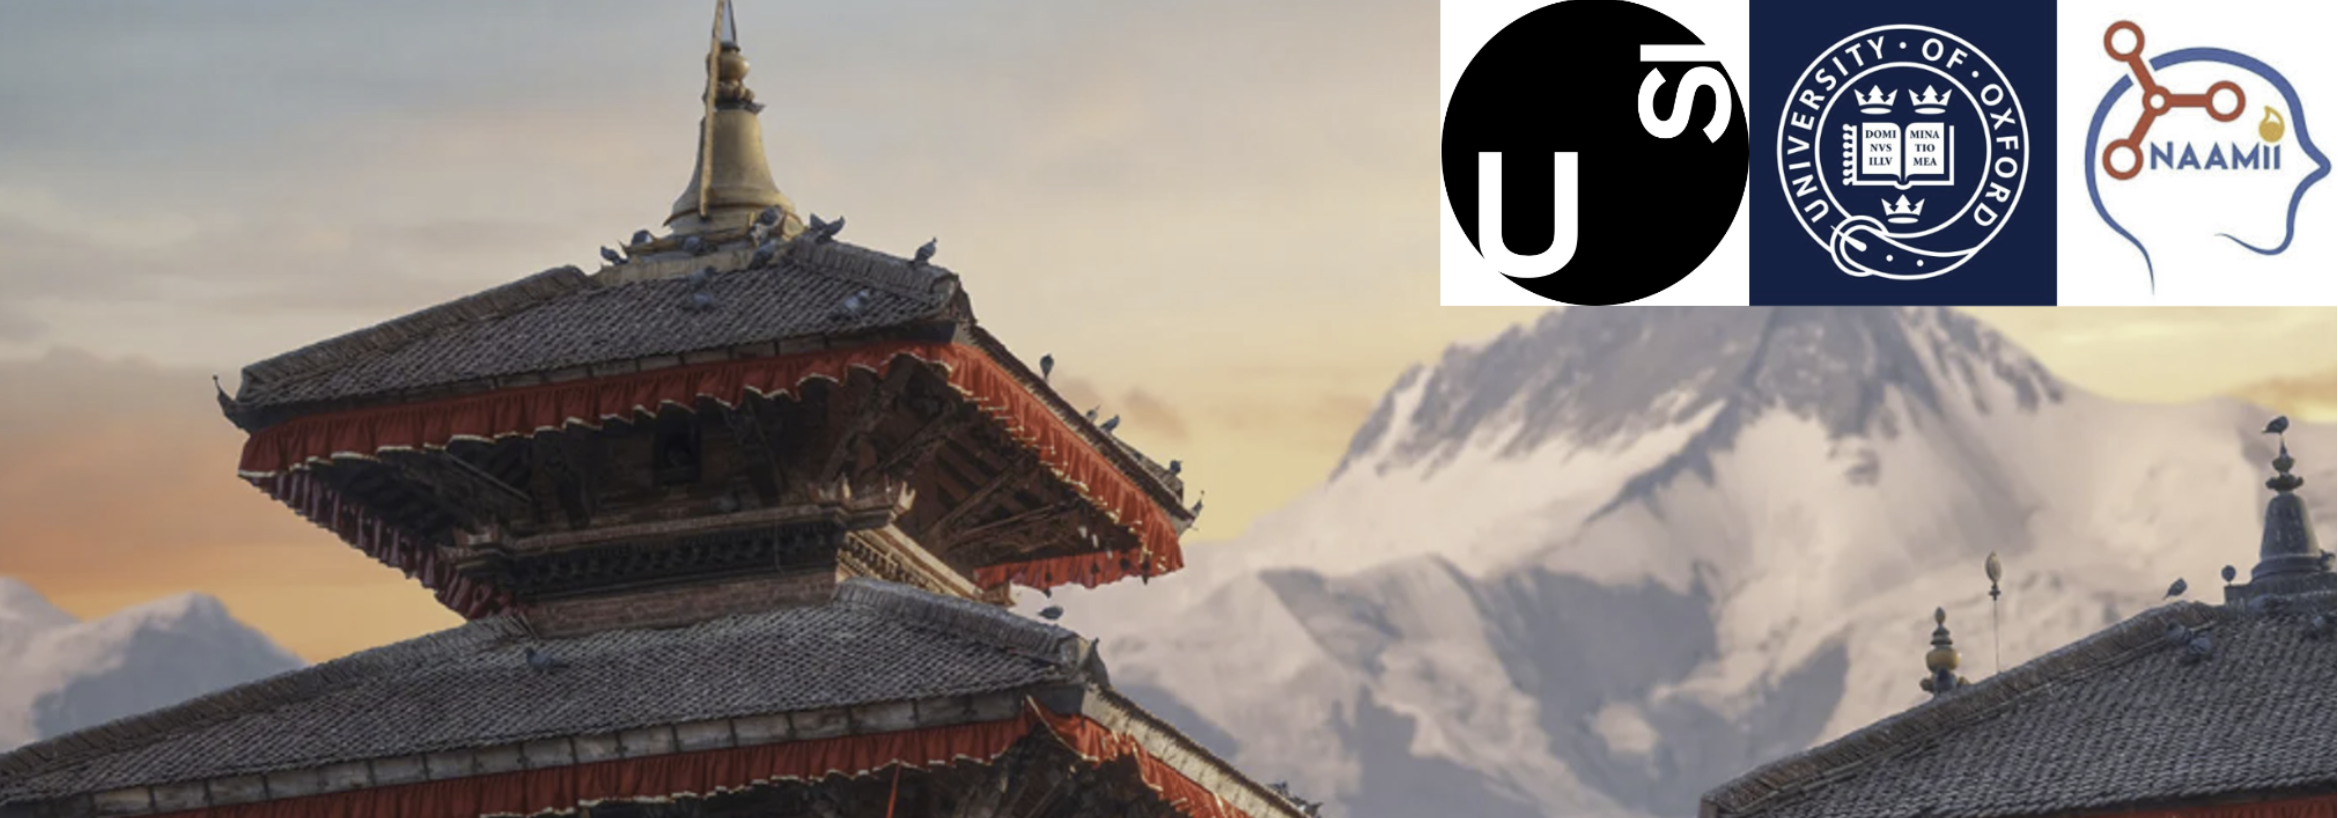

## Introduction

Welcome to this **Colab notebook** where we’ll continue our exploration of Graph Neural Networks (GNNs) and venture into the fascinating world of **Invariance & equivariance** in Geometric Deep Learning. If you’ve followed along with the previous tutorials on GNN basics, you already know how powerful they can be for modeling data that naturally forms graphs—like citation networks or molecules.

In this notebook, we will take GNNs a step further by getting into **Invariant & Equivariant GNNs**, which explicitly incorporate geometric information ( 3D positions of atoms in a molecule) into the learning process. These architectures are particularly important in fields like **computational chemistry, physics, and materials science**, where the spatial arrangement of components is crucial to understanding the system’s properties.

Here’s a brief overview of what to expect:

1. **Recap of GNN Fundamentals**  
   - We’ll briefly revisit how molecular graphs are represented (nodes = atoms, edges = bonds) and how PyTorch Geometric simplifies building and training GNN models.
   
2. **Introduction to Invariance**  
   - We’ll discuss what *Invariance and equivariance* mean in the context of GNNs and why it matters when dealing with 3D structures.  
   - We’ll look at how symmetry groups (rotations, translations) can be leveraged to build models that respect the underlying geometry of molecules.

3. **Practical Implementation**  
   - Using the **QM9** dataset, we’ll build and train our own Invariant GNN to predict molecular properties such as orbital energy.  
   - We’ll highlight key differences between a standard GNN and an Invariant GNN, in terms of both **implementation** and **performance**.

---


### **Section 1: Recap of GNN Fundamentals with Message Passing Neural Networks (MPNNs)**

Before diving into **Invariant GNNs**, let’s revisit the foundational concepts of **Graph Neural Networks (GNNs)**, specifically focusing on the **Message Passing Neural Network (MPNN)** framework. Understanding MPNNs is crucial as they provide a generalized and flexible approach to handling graph-structured data.

### 1.1 Graph Representation

A molecule can be naturally represented as a **graph** where:
- **Nodes** (or *vertices*) represent **atoms**.
- **Edges** indicate **bonds** between atoms.

In **PyTorch Geometric**, these components are typically stored as:
- `data.x`: A tensor containing **node (atom) features**.
- `data.pos` A tensor containing the **3D Coordinates** of atoms in a molecule.
- `data.edge_index`: A tensor that encodes the pairs of nodes that share an edge (i.e., bonded atoms).


### 1.2 The Message Passing Paradigm in MPNNs

**Message Passing Neural Networks (MPNNs)** follow the **message passing** framework. This paradigm allows nodes to exchange and aggregate information from their neighbors iteratively. The general update rule for MPNNs can be expressed as:

$$
\mathbf{\tilde{h}}_i = \phi\left(\mathbf{h}_i, \bigoplus_{j \in \mathcal{N}(i)} \psi\left(\mathbf{h}_i, \mathbf{h}_j, \mathbf{e}_{i,j}\right)\right)
$$

Where:
- $\mathbf{h}_i$ is the **current feature vector** of node $i$.
- $\mathbf{e}_{i,j}$ are the **features of the edge** between nodes $i$ and $j$.
- $\psi: \mathbb{R}^k \times \mathbb{R}^k \times \mathbb{R}^{k_e} \rightarrow \mathbb{R}^{k'}$ is the **message function** that determines the information sent from neighbor $j$ to target node $i$.
- $\bigoplus$ is a **permutation invariant operator** (e.g., sum, mean, max) that aggregates messages from all neighbors.
- $\phi: \mathbb{R}^k \times \mathbb{R}^{k'} \rightarrow \mathbb{R}^{k''}$ is the **update function** that refines the feature of node $i$ based on its current state and the aggregated messages.


### 1.3 Graph-Level Predictions

In **molecular property prediction**, the goal is often to produce **graph-level** outputs (e.g., dipole moment, orbital energy) rather than node-level predictions. We can do this by global pooling operation:

- **Global Pooling:** Aggregate node embeddings using operations like *mean*, *max*, or *sum* pooling, followed by a fully connected layer for the final prediction.
  
  ```python
  from torch_geometric.nn import global_mean_pool
  
  # Assume x contains node features and batch contains graph indices
  graph_embedding = global_mean_pool(x, batch)


### **Example: Visualizing a Molecule in 3D with RDKit and py3dmol**

To deepen our understanding of molecular graph representations, let's explore both **2D** and **3D** visualizations of a complex molecule: **Caffeine**.
**Caffeine** is a central nervous system stimulant belonging to the methylxanthine class and Its molecular formula is **C₈H₁₀N₄O₂**.

we'll use the **RDKit** library, which is a powerful toolkit for cheminformatics. Additionally, we'll utilize **py3Dmol** for interactive 3D visualization within the Colab notebook.



First, ensure that the necessary libraries are installed. We'll need `rdkit` for molecular representations and `py3Dmol` for 3D visualization, along with pytorch geomtric.

In [1]:
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [2]:
# Install PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=2.4.0+cu121
"""
%env TORCH=2.4.0+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
# Install RDKit and py3Dmol
!pip install rdkit-pypi
!pip install py3Dmol


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.6 MB/s eta 0:00:00


In [4]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    rdCoordGen,
)
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  # Use higher quality images for molecules


In [5]:
import random
import numpy as np
import torch
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
# Helper functions to visualize molecules in 3D

def create_view(mol, view, grid):
    mb = Chem.MolToMolBlock(mol)
    view.removeAllModels(viewer=grid)
    view.addModel(mb,'sdf', viewer=grid)
    view.setStyle({'model':0},{'stick': {}}, viewer=grid)
    view.zoomTo(viewer=grid)
    return view

def view_mol(mol, width=600, height=600):
    view = py3Dmol.view(width=width, height=height, linked=False, viewergrid=(1,1))
    create_view(mol, view, grid=(0, 0))
    return view


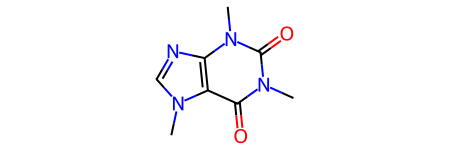

In [7]:
# 2D Visualization

caffeine = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
rdCoordGen.AddCoords(caffeine)
caffeine

In [8]:
# 3D Visualization

view_mol(caffeine)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## **Section 2: Exploring the QM9 Dataset with PyTorch Geometric**

Having recapped the fundamentals of GNNs, let’s now turn our attention to a well-known molecular dataset called **QM9**. This dataset is widely used in benchmarking **Graph Neural Networks** for molecular property prediction, especially in the context of 3D geometry.

### 2.1 About QM9

- **Size**: ~130,000 small organic molecules.
- **Targets**: different regression tasks (e.g., dipole moment, orbital energy).
- **Features**:
  - **Node Features**: Atomic information (atomic number, etc.).
  - **Edge Features**: Bond types, adjacency.
  - **3D Coordinates**: The $\texttt{pos}$ tensor in PyTorch Geometric records the 3D position of each atom.


### 2.2 Loading QM9 in PyTorch Geometric

Below is a snippet to load the QM9 dataset. Note that PyG automatically downloads the data if it’s not already present.


In [9]:
import torch_geometric
from torch_geometric.datasets import QM9

#------------------------------------------------------------------------------
# 1. Load the QM9 dataset
#    By default, root='data/QM9' will store the dataset in a "data/QM9" folder.
dataset = QM9(root='data/QM9')

print(f"Number of molecules in QM9: {len(dataset)}")

#------------------------------------------------------------------------------
# 2. Let's inspect one sample
sample_data = dataset[0]
print(sample_data)

# The 'sample_data' is a PyG 'Data' object with attributes like:
# - x         (node features)
# - pos       (3D coordinates)
# - y         (property labels: shape [1, 19] for QM9)
# - z         (atomic numbers)
# - edge_index(edge connections)
# - edge_attr (edge attributes)

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:19<00:00, 671.90it/s]
Done!


Number of molecules in QM9: 130831
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


## **Task 2.1: Visualizing QM9 Samples in 3D**

In this mini exercise, we will:
1. Select a few samples from the QM9 dataset.
2. Convert each sample in PyG `Data` object into an RDKit molecule.
3. Use our custom `view_mol` function to display the 3D structure directly in this notebook.

Below is a starter code for your task. You will find two placeholders marked by the comments ###### YOUR CODE #######. Your task is to complete the code by filling in these sections.

---


In [10]:
import torch
import random
from rdkit.Chem import AllChem


# Helper function to convert PyG Data to RDKit molecule
def pyg_to_rdkit(data):
    from rdkit import Chem
    mol = Chem.RWMol()

    # Add atoms
    for atomic_num in data.z.tolist():
        mol.AddAtom(Chem.Atom(int(atomic_num)))

    # Add bonds (simple single-bond assumption)
    edges = data.edge_index.numpy()
    for src, dst in zip(edges[0], edges[1]):
        if src < dst:
            mol.AddBond(int(src), int(dst), Chem.BondType.SINGLE)

    # 3D coordinates
    conf = Chem.Conformer(mol.GetNumAtoms())
    for i, pos in enumerate(data.pos):
        x, y, z = pos.tolist()
        conf.SetAtomPosition(i, (x, y, z))
    mol.AddConformer(conf)

    return mol.GetMol()


In [12]:
# 1. Pick some random indices from the dataset
indices = random.sample(range(len(dataset)), 3)

# 2. For each index, convert Data -> RDKit molecule -> Visualize
for idx in indices:
    ###### YOUR CODE #######
    data_sample = dataset[idx]
    mol = pyg_to_rdkit(data_sample)
    ###### YOUR CODE #######

    # Visualize
    display(view_mol(mol))


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## **Section 3: Training and Evaluating an MPNN on QM9**

In this section, we’ll walk through the key steps to **train** and **evaluate** a simple **Message Passing Neural Network (MPNN)** on a **subset** of the QM9 dataset. To keep things lightweight, we will:

3.1. **Select a random 3,000-molecule subset** of QM9. We will also convert each molecule to a fully-connected graph (all nodes are connected to each other) and remove the self-loops.    
3.2. **Split** it into **500** for training, **500** for validation, **2,000** for testing.  
3.3. **Normalize** the target property (we will select orbital energy, HOMO) using the *mean* and *standard deviation* from the training set.   
3.4. **Train an MPNN model** to predict the chosen property (HOMO) and evaluat its performance.

### 3.1. Select a random 3,000-molecule subset of QM9

In [13]:
import random
import numpy as np
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader

# ------------------------------------
# Load the full QM9 dataset
# ------------------------------------
dataset = QM9(root='data/QM9')

print(f"Total molecules in QM9: {len(dataset)}")

# ------------------------------------
# Randomly select 3,000 molecules
# ------------------------------------
sample_indices = random.sample(range(len(dataset)), 3000)
pre_subset_dataset = dataset[sample_indices]

print(f"Random subset size: {len(pre_subset_dataset)}")


Total molecules in QM9: 130831
Random subset size: 3000


Convert each molecule in our subset to a fully connected graph.

In [14]:
import copy
from torch_geometric.utils import remove_self_loops

# Helper function that modify edge_index in PyG data object to inlcude edges between all nodes

def complete_graph(data):
    data = copy.copy(data)
    device = data.edge_index.device

    row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
    col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

    row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
    col = col.repeat(data.num_nodes)
    edge_index = torch.stack([row, col], dim=0)

    edge_attr = None
    if data.edge_attr is not None:
        idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
        size = list(data.edge_attr.size())
        size[0] = data.num_nodes * data.num_nodes
        edge_attr = data.edge_attr.new_zeros(size)
        edge_attr[idx] = data.edge_attr

    edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
    data.edge_attr = edge_attr
    data.edge_index = edge_index

    return data

In [15]:
# Iterate over the subset and convert each graph to fully connected one

subset_dataset = []
for i in range(len(pre_subset_dataset)):
    subset_dataset.append(complete_graph(pre_subset_dataset[i]))

###  3.2. Splitting the subset into Train/Val/Test and Creating PyG DataLoaders.
We’ll take the first 500 molecules for training, the next 500 for validation, and the last 2,000 for testing.

In [16]:
train_dataset = subset_dataset[:500]
val_dataset   = subset_dataset[500:1000]
test_dataset  = subset_dataset[1000:3000]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 500, Val: 500, Test: 2000


Create PyG dataloaders

In [17]:
from torch_geometric.loader import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

### 3.3 Normalizing the Target
Typically, HOMO property is the third entry in data.y[:, 2]. We’ll compute the mean and std of the training set, then we apply that to normalize the target values.

In [18]:
# HOMO property
target_idx = 2

# Collect all the required property in the training set
train_targets = []
for data in train_dataset:
    # y shape [1, 19]
    target = data.y[0, target_idx].item()
    train_targets.append(target)

train_targets = np.array(train_targets)
mean_target = np.mean(train_targets)
std_target  = np.std(train_targets)

print(f"Training set Mean and Std of the chosen property (HOMO): {mean_target:.4f}, Std: {std_target:.4f}")

# Normalize targets in training data

def normalize_target(d, mean_val, std_val):
    d.y[0, target_idx] = (d.y[0, target_idx] - mean_val) / std_val
    return d

for d in train_dataset:
    normalize_target(d, mean_target, std_target)


Training set Mean and Std of the chosen property (HOMO): -6.5147, Std: 0.5709


### 3.4. Train an MPNN model to predict the chosen property (HOMO) and evaluat its performance.

Implementation of an MPNN model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import Data

###############################################################################
# 1. A Simple MPNN Layer (No Edge Features)
###############################################################################
class MPNN_layer(MessagePassing):
    """
    A basic Message Passing layer with 'mean' aggregation.

    - No edge features are used.
    - The message function constructed from source nodes j to target nodes i.
    """

    def __init__(self, in_channels: int, out_channels: int):
        """
        Args:
            in_channels (int): Number of input node features.
            out_channels (int): Number of output node features.
        """
        super().__init__(aggr='mean')  # "mean" aggregation

        # MLP netwrok (message function)
        self.mlp = nn.Sequential(
            nn.Linear(2*in_channels, out_channels), nn.ReLU(),
            nn.Linear(out_channels, out_channels), nn.ReLU()
          )

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the message passing layer.

        Args:
            x (torch.Tensor): Node feature matrix of shape [N, in_channels]. N is the total num of nodes in the batched graphs.
            edge_index (torch.Tensor): Graph connectivity of shape [2, E]. E  is the total num of edges in the batched graphs.

        Returns:
            torch.Tensor: Updated node features of shape [N, out_channels].
        """

        # Perform message passing
        x = self.propagate(edge_index, x=x)

        return x

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor) -> torch.Tensor:
        """
        Constructs messages from source nodes j to target nodes i.

        Args:
            x_i (torch.Tensor): node embeddings of shape [E, out_channels].
            x_j (torch.Tensor): Neighbor node embeddings of shape [E, out_channels].

        Returns:
            torch.Tensor: Messages passed along edges of shape [E, out_channels].
        """
        msg = torch.cat([x_i, x_j], dim=-1) # No edge features; pass node and neighbor features directly
        return self.mlp(msg)


###############################################################################
# 2. A Flexible MPNN Model
###############################################################################
class MPNNModel(nn.Module):
    """
    A multi-layer GNN that stacks 'num_layers' instances of MPNN_layer, followed
    by global mean pooling and a final linear layer for regression.

    This model does NOT use edge features. It also ignores 3D coordinates by default.
    """

    def __init__(
        self,
        node_feat_dim: int,
        hidden_dim: int = 64,
        out_dim: int = 1,
        num_layers: int = 4
    ):
        """
        Args:
            node_feat_dim (int): Dimensionality of node features in data.x.
            hidden_dim (int): Hidden dimension for intermediate GNN layers.
            out_dim (int): Output dimension (e.g., 1 for regression).
            num_layers (int): Number of stacked GNN layers.
        """
        super().__init__()

        self.linear_in = nn.Linear(node_feat_dim, hidden_dim)

        # Store the layers in a ModuleList
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(MPNN_layer(hidden_dim, hidden_dim))

        # Final linear layer for scalar prediction
        self.lin_final = nn.Linear(hidden_dim, out_dim)

    def forward(
        self,
        data: Data,
        batch: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass for the entire MPNN model.

        Args:
            data: (PyG.Data) - batch of pytorch geometric graphs
            batch (torch.Tensor): Batch assignments [N], mapping each node to a graph.

        Returns:
            torch.Tensor: Scalar predictions for each graph, shape [batch_size].
        """
        x = data.x
        x = F.relu(self.linear_in(x))
        edge_index = data.edge_index
        # Pass through each MPNN layer
        for layer in self.layers:
            x = layer(x, edge_index)

        # Global pooling -> single vector per graph
        x = global_mean_pool(x, batch)

        # Final linear -> scalar output
        out = self.lin_final(x)  # shape [batch_size, out_dim]
        return out.squeeze(-1)    # shape [batch_size]



## **Task 3.1: Write the correct equation for the MPNN layer implemented above**

Answer here

Train and test our MPNN model

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Initialize MPNN model
node_feat_dim = train_dataset[0].x.size(1)
model = MPNNModel(node_feat_dim=node_feat_dim, hidden_dim=64, out_dim=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss(reduction="mean")  # MAE

# Train function
def train_epoch(loader):
    model.train()
    epoch_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        batch = data.batch
        pred = model(data, batch)
        # data.y shape: [batch_size, 19], we want data.y[:,target_idx]
        target = data.y[:, target_idx]
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * data.num_graphs
    return epoch_loss / len(loader.dataset)

# Evaluation function (MAE in normalized space)
def evaluate(loader, std, mean):
    model.eval()
    mae = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            batch = data.batch
            pred = model(data, batch)
            target = data.y[:, target_idx]
            mae += F.l1_loss(pred * std + mean, target, reduction='mean').item()
    return 1000*mae / len(loader.dataset)

num_epochs = 100
for epoch in range(1, num_epochs+1):
    trn_loss = train_epoch(train_loader)
    val_mae  = evaluate(val_loader, std_target, mean_target)
    test_mae = evaluate(test_loader, std_target, mean_target)

    print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {trn_loss:.4f} | Val MAE: {val_mae:.4f} | Test MAE: {test_mae:.4f}")


Using device: cuda
Epoch [1/100] | Train Loss: 0.7585 | Val MAE: 14.1719 | Test MAE: 13.8597
Epoch [2/100] | Train Loss: 0.7552 | Val MAE: 14.2349 | Test MAE: 13.9661
Epoch [3/100] | Train Loss: 0.7549 | Val MAE: 14.2248 | Test MAE: 13.9522
Epoch [4/100] | Train Loss: 0.7552 | Val MAE: 14.1936 | Test MAE: 13.9048
Epoch [5/100] | Train Loss: 0.7545 | Val MAE: 14.2174 | Test MAE: 13.9418
Epoch [6/100] | Train Loss: 0.7550 | Val MAE: 14.2548 | Test MAE: 13.9924
Epoch [7/100] | Train Loss: 0.7548 | Val MAE: 14.2151 | Test MAE: 13.9382
Epoch [8/100] | Train Loss: 0.7547 | Val MAE: 14.2322 | Test MAE: 13.9624
Epoch [9/100] | Train Loss: 0.7547 | Val MAE: 14.2167 | Test MAE: 13.9407
Epoch [10/100] | Train Loss: 0.7546 | Val MAE: 14.2326 | Test MAE: 13.9631
Epoch [11/100] | Train Loss: 0.7550 | Val MAE: 14.2088 | Test MAE: 13.9282
Epoch [12/100] | Train Loss: 0.7546 | Val MAE: 14.2213 | Test MAE: 13.9475
Epoch [13/100] | Train Loss: 0.7547 | Val MAE: 14.2327 | Test MAE: 13.9632
Epoch [14/100] 

## **Task 3.2: Incorporate 3D Coordinates into the MPNN model**

In the default **`MPNNModel`** code, we used only the atom-level features in `data.x`. However, **QM9** provides **3D coordinates** in `data.pos`. The goal of this task is to **concatenate** these 3D coordinates to the node features, and then re-train the model to see if the performance improves.

Below is a starter code for your task. We show you where to inject the coordinate and how to adjust the model. You will find two placeholders marked by the comments ###### YOUR CODE #######. Your task is to complete the code by filling in these sections.

---




In [ ]:
###############################################################################
# 2. An MPNN Model that incorporate 3D coordinates
###############################################################################
class CoordMPNNModel(nn.Module):
    """
    A multi-layer GNN that stacks 'num_layers' instances of MPNN_layer, followed
    by global mean pooling and a final linear layer for regression.

    This model concatenate 3D coorinates to the node features.
    """

    def __init__(
        self,
        node_feat_dim: int,
        hidden_dim: int = 64,
        out_dim: int = 1,
        num_layers: int = 4
    ):
        """
        Args:
            node_feat_dim (int): Dimensionality of node features in data.x.
            hidden_dim (int): Hidden dimension for intermediate GNN layers.
            out_dim (int): Output dimension (e.g., 1 for regression).
            num_layers (int): Number of stacked GNN layers.
        """
        super().__init__()

        ###### YOUR CODE #######
        ## modify the input dimention of the first linear layer and add the coordinate dim (3)
        self.linear_in = nn.linear(node_feat_dim, hidden_dim, dim=3)
        ###### YOUR CODE #######

        # Store the layers in a ModuleList
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(MPNN_layer(hidden_dim, hidden_dim))

        # Final linear layer for scalar prediction
        self.lin_final = nn.Linear(hidden_dim, out_dim)

    def forward(
        self,
        data: Data,
        batch: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass for the entire MPNN model.

        Args:
            data: (PyG.Data) - batch of pytorch geometric graphs
            batch (torch.Tensor): Batch assignments [N], mapping each node to a graph.

        Returns:
            torch.Tensor: Scalar predictions for each graph, shape [batch_size].
        """
        x = data.x
        ###### YOUR CODE #######
        ## concatenate the 3D coordinates in data.pos to the node features x
        x = ...
        ###### YOUR CODE #######
        x = F.relu(self.linear_in(x))
        edge_index = data.edge_index
        # Pass through each MPNN layer
        for layer in self.layers:
            x = layer(x, edge_index)

        # Global pooling -> single vector per graph
        x = global_mean_pool(x, batch)

        # Final linear -> scalar output
        out = self.lin_final(x)  # shape [batch_size, out_dim]
        return out.squeeze(-1)    # shape [batch_size]

In [ ]:
# Initialize CoordMPNN model
node_feat_dim = train_dataset[0].x.size(1)
model = CoordMPNNModel(node_feat_dim=node_feat_dim, hidden_dim=64, out_dim=1).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss(reduction="mean")  # MAE


num_epochs = 100
for epoch in range(1, num_epochs+1):
    trn_loss = train_epoch(train_loader)
    val_mae  = evaluate(val_loader, std_target, mean_target)
    test_mae = evaluate(test_loader, std_target, mean_target)

    print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {trn_loss:.4f} | Val MAE: {val_mae:.4f} | Test MAE: {test_mae:.4f}")

Epoch [1/100] | Train Loss: 0.7554 | Val MAE: 14.2135 | Test MAE: 13.9358
Epoch [2/100] | Train Loss: 0.7546 | Val MAE: 14.2131 | Test MAE: 13.9352
Epoch [3/100] | Train Loss: 0.7547 | Val MAE: 14.2242 | Test MAE: 13.9518
Epoch [4/100] | Train Loss: 0.7547 | Val MAE: 14.2120 | Test MAE: 13.9343
Epoch [5/100] | Train Loss: 0.7548 | Val MAE: 14.2303 | Test MAE: 13.9628
Epoch [6/100] | Train Loss: 0.7540 | Val MAE: 14.1435 | Test MAE: 13.8553
Epoch [7/100] | Train Loss: 0.7516 | Val MAE: 14.1079 | Test MAE: 13.7863
Epoch [8/100] | Train Loss: 0.7465 | Val MAE: 14.1850 | Test MAE: 13.9408
Epoch [9/100] | Train Loss: 0.7439 | Val MAE: 14.1919 | Test MAE: 13.9497
Epoch [10/100] | Train Loss: 0.7476 | Val MAE: 14.1383 | Test MAE: 13.8142
Epoch [11/100] | Train Loss: 0.7397 | Val MAE: 14.1205 | Test MAE: 13.8481
Epoch [12/100] | Train Loss: 0.7388 | Val MAE: 14.1303 | Test MAE: 13.8304
Epoch [13/100] | Train Loss: 0.7425 | Val MAE: 14.1555 | Test MAE: 13.9151
Epoch [14/100] | Train Loss: 0.740

What did you notice on the perforamcne of the MPNN model when including the 3D coordinates compared to the MPNN without the coordinates?

Answer here

## **Section 4: Invariance and Equivariance to 3D Rotations & Translations**

**Recap:** Let $ f $ be a function that takes an input $ x $ (e.g., a molecule, image, or geometric structure) and produces an output $ f(x) $. We also have a **group of transformations** $ \mathcal{G} $, such as all possible **3D rotations** or **translations**.

1. **Invariance**  
   A function $ f $ is **invariant** to transformations in $ \mathcal{G} $ if applying **any** transformation $ g \in \mathcal{G} $ to the input **does not change** the output:
   $$
   f(g \cdot x) \;=\; f(x)\quad\text{for all}\; g \in \mathcal{G}.
   $$
   **Example**: A scalar property (like total energy or the magnitude of a dipole moment) that does not depend on the molecule’s absolute orientation in 3D space.

2. **Equivariance**  
   A function $ f $ is **equivariant** to transformations in $ \mathcal{G} $ if applying a transformation $ g $ to the input results in a **corresponding** transformation of the output:
   $$
   f(g \cdot x) \;=\; g \cdot f(x)\quad\text{for all}\; g \in \mathcal{G}.
   $$
   **Example**: A **vector** property (like force vector) that should rotate exactly as the molecule does in 3D space. If the molecule is rotated by $ g $, the predicted vector should rotate accordingly.


In molecular property prediction, **3D geometry** plays a central role. Ideally, a model that leverages atom coordinates should produce **consistent** (or properly *transformed*) outputs regardless of how the molecule is **rotated** or **translated** in space.  

- **Translational Invariance**: Shifting a molecule in 3D space should **not** change its predicted property (e.g., dipole moment).  
- **Rotational Invariance**: Rotating a molecule should similarly **not** change the predicted scalar property.

However, a standard MPNN that simply appends coordinates to node features is **not** necessarily invariant to these transformations. In this section, we will:

1. **Test** the MPNN model to see if it changes outputs when the input molecule is translated or rotated.  
3. Implement an **InvariantMPNN** model that is better suited for these geometric transformations.  
1. **Test** our **InvariantMPNN** model to check whether the model indeed respects invariance.   
4. Re-run **train/evaluation** to check whether the **InvariantMPNN** model improved the performance.

---


### 4.1. Testing Invariance

The following snippet shows how you can **rotate** and **translate** a molecule’s 3D coordinates, then we will use it to see if the output of an MPNN model changes when applying such transformations.


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from scipy.stats import ortho_group

def generate_random_orthogonal_matrix(dim=3):
    """
    Creates a random orthogonal matrix (dimension = dim) using scipy's ortho_group.
    """
    # ortho_group.rvs() gives a random orthonormal matrix
    # Convert to torch.Tensor
    Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
    return Q

def random_translation_vector(dim=3):
    """
    Returns a random translation vector (dimension = dim),
    each component ~ Uniform(0, 1).
    """
    return torch.rand(dim)

def apply_random_rotation_translation(data, dim=3):
    """
    Clones the PyG Data object and applies:
      1. A random orthogonal rotation.
      2. A random translation.
    Returns the transformed copy.
    """
    # Clone to avoid modifying original data
    data_rot_trans = data.clone()
    Q = generate_random_orthogonal_matrix(dim=dim)
    t = random_translation_vector(dim=dim)

    # Rotate and translate positions
    # data.pos shape: [num_nodes, 3]
    data_rot_trans.pos = data_rot_trans.pos @ Q.T + t
    return data_rot_trans

def check_invariance(model, data):
    """
    Single-test function:
    1. Runs forward pass on original data
    2. Applies random rotation + translation
    3. Runs forward pass again
    4. Returns True if outputs are close, False otherwise
    """
    # Move data to same device as the model's parameters (if they exist)
    device = next(model.parameters(), torch.empty(0)).device if hasattr(model, 'parameters') else 'cpu'
    data = data.to(device)

    # Forward pass on original data
    if hasattr(model, '__call__') and not isinstance(model, MessagePassing):
        # e.g., MPNNModel: forward pass by calling model(data)
        out_original = model(data, data.batch)
    else:
        # e.g., a GNN layer: forward pass with (x, pos, edge_index, edge_attr?)
        out_original = model(data.x, data.pos, data.edge_index, data.edge_attr)

    # Generate a randomly rotated & translated version of data
    data_rt = apply_random_rotation_translation(data.cpu()).to(device)

    # Forward pass on the transformed data
    if hasattr(model, '__call__') and not isinstance(model, MessagePassing):
        out_transformed = model(data_rt, data_rt.batch)
    else:
        out_transformed = model(data_rt.x, data_rt.pos, data_rt.edge_index, data_rt.edge_attr)

    # Check invariance (allclose with a tolerance)
    # For many tasks, small numerical differences are okay.
    return torch.allclose(out_original, out_transformed, atol=1e-4)

def invariance_test_suite(model, dataset, num_tests=5):
    """
    Repeatedly picks random samples from the dataset,
    applies the invariance check, and reports results.

    Args:
        model: MPNN model or GNN layer to be tested.
        dataset: A PyG dataset or list of Data objects.
        num_tests: Number of random samples to test.

    Returns:
        total_pass (int): how many times invariance check passed
        total_tested (int): total tests performed
    """
    total_pass = 0
    total_tested = 0

    for _ in range(num_tests):
        # Randomly pick an index
        idx = np.random.randint(len(dataset))
        data_sample = dataset[idx]

        # If data_sample is not yet batched, we can artificially set data_sample.batch
        # to zeros or do a single-graph batch. (Depends on your model's forward signature)
        if not hasattr(data_sample, 'batch'):
            import torch
            data_sample.batch = torch.zeros(data_sample.num_nodes, dtype=torch.long)

        # Run test
        passed = check_invariance(model, data_sample)
        total_pass += int(passed)
        total_tested += 1

        print(f"Test #{_+1}: Invariance Check = {passed}")

    print(f"\nSummary: {total_pass}/{total_tested} tests passed.")
    return total_pass, total_tested


In [ ]:
# test_invariance of the MPNN model:
invariance_test_suite(model, train_dataset, num_tests=5)


Test #1: Invariance Check = False
Test #2: Invariance Check = False
Test #3: Invariance Check = False
Test #4: Invariance Check = False
Test #5: Invariance Check = False

Summary: 0/5 tests passed.


(0, 5)

## **Task 4.1: Implement an InvariantMPNN model**

Implement an InvariantMPNN model that ensures the final prediction is invariant to 3D rotations and translations.
You can acheive invariance by multiple ways—e.g., using internal distances between atoms, or geometric features like angles. The simplest approach might be to rely on pairwise distances rather than raw coordinates.
Below is a starter code for your task. You will find two placeholders marked by the comments ###### YOUR CODE #######.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import Data

###############################################################################
# 1. An Invariant MPNN Layer
###############################################################################

class InvariantMPNNLayer(MessagePassing):
    """
    An Invariant Message Passing layer with 'mean' aggregation.

    - No edge features are used.
    - The message function simply passes neighbor embeddings x_j.
    """

    def __init__(self, in_channels: int, out_channels: int):
        """
        Args:
            in_channels (int): Number of input node features.
            out_channels (int): Number of output node features.
        """
        super().__init__(aggr='mean')  # "mean" aggregation

        # MLP netwrok (message function)
        ## modify the input dimension of the mlp to add another dimension for distances

        ###### YOUR CODE #######
        self.mlp = ...
        ###### YOUR CODE #######

    def forward(self, x: torch.Tensor, pos: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the message passing layer.

        Args:
            x (torch.Tensor): Node feature matrix of shape [N, in_channels].
            edge_index (torch.Tensor): Graph connectivity of shape [2, E]

        Returns:
            torch.Tensor: Updated node features of shape [N, out_channels].
        """


        # Calculate the pairwise distances between atoms
        ###### YOUR CODE #######
        pos_diff = ...
        distances  = ...
        ###### YOUR CODE #######
        # Perform message passing
        x = self.propagate(edge_index, x=x, distances=distances)

        return x

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, distances: torch.Tensor) -> torch.Tensor:
        """
        Constructs messages from source nodes j to target nodes i.

        Args:
            x_i (torch.Tensor): node embeddings of shape [E, out_channels].
            x_j (torch.Tensor): Neighbor node embeddings of shape [E, out_channels].
            distances (torch.Tensor): Distances between nodes of shape [E].

        Returns:
            torch.Tensor: Messages passed along edges of shape [E, out_channels].
        """
        ###### YOUR CODE #######
        # concatenate node, neighbor features, and distances.
        msg = ...
        ###### YOUR CODE #######
        return self.mlp(msg)



###############################################################################
# 2. A Invariant MPNN Model
###############################################################################

class InvariantMPNNModel(nn.Module):
    """
    A multi-layer GNN that stacks 'num_layers' instances of InvariantMPNNLayer, followed
    by global mean pooling and a final linear layer for regression.
    """

    def __init__(
        self,
        node_feat_dim: int,
        hidden_dim: int = 64,
        out_dim: int = 1,
        num_layers: int = 4
    ):
        """
        Args:
            node_feat_dim (int): Dimensionality of node features in data.x.
            hidden_dim (int): Hidden dimension for intermediate GNN layers.
            out_dim (int): Output dimension (e.g., 1 for regression).
            num_layers (int): Number of stacked GNN layers.
        """
        super().__init__()

        self.linear_in = nn.Linear(node_feat_dim, hidden_dim)

        # Store the layers in a ModuleList
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(InvariantMPNNLayer(hidden_dim, hidden_dim))

        # Final linear layer for scalar prediction
        self.lin_final = nn.Linear(hidden_dim, out_dim)

    def forward(
        self,
        data: Data,
        batch: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass for the entire MPNN model.

        Args:
            data: (PyG.Data) - batch of pytorch geometric graphs
            batch (torch.Tensor): Batch assignments [N], mapping each node to a graph.

        Returns:
            torch.Tensor: Scalar predictions for each graph, shape [batch_size].
        """
        x = data.x
        x = F.relu(self.linear_in(x))
        edge_index = data.edge_index
        pos = data.pos
        # Pass through each GNN layer
        for layer in self.layers:
            x = layer(x, pos, edge_index)

        # Global pooling -> single vector per graph
        x = global_mean_pool(x, batch)

        # Final linear -> scalar output
        out = self.lin_final(x)  # shape [batch_size, out_dim]
        return out.squeeze(-1)    # shape [batch_size]


## **Task 4.2: Write the correct equation for the InvariantMPNN layer you have implemented**

Answer here

### 4.2. Test InvariantMPNN model using our invariant test.

In [ ]:
# Initialize model
node_feat_dim = train_dataset[0].x.size(1)
model = InvariantMPNNModel(node_feat_dim=node_feat_dim, hidden_dim=64, out_dim=1).to(device)

In [ ]:
# test_invariance of the InvariantMPNN model:
invariance_test_suite(model, train_dataset, num_tests=5)

Test #1: Invariance Check = True
Test #2: Invariance Check = True
Test #3: Invariance Check = True
Test #4: Invariance Check = True
Test #5: Invariance Check = True

Summary: 5/5 tests passed.


(5, 5)

Does the InvariantMPNNModel pass the invariant test?

Answer here

### 4.3. Train an InvariantMPNN model on the subset of QM9.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.L1Loss(reduction="mean")  # MAE


num_epochs = 100
for epoch in range(1, num_epochs+1):
    trn_loss = train_epoch(train_loader)
    val_mae  = evaluate(val_loader, std_target, mean_target)
    test_mae = evaluate(test_loader, std_target, mean_target)

    print(f"Epoch [{epoch}/{num_epochs}] | Train Loss: {trn_loss:.4f} | Val MAE: {val_mae:.4f} | Test MAE: {test_mae:.4f}")

Epoch [1/100] | Train Loss: 0.7642 | Val MAE: 14.2211 | Test MAE: 13.9505
Epoch [2/100] | Train Loss: 0.7543 | Val MAE: 14.2567 | Test MAE: 14.0020
Epoch [3/100] | Train Loss: 0.7538 | Val MAE: 14.1925 | Test MAE: 13.9047
Epoch [4/100] | Train Loss: 0.7545 | Val MAE: 14.2386 | Test MAE: 13.9794
Epoch [5/100] | Train Loss: 0.7533 | Val MAE: 14.2278 | Test MAE: 13.9627
Epoch [6/100] | Train Loss: 0.7568 | Val MAE: 14.2121 | Test MAE: 13.9400
Epoch [7/100] | Train Loss: 0.7538 | Val MAE: 14.2427 | Test MAE: 13.9858
Epoch [8/100] | Train Loss: 0.7531 | Val MAE: 14.2046 | Test MAE: 13.9284
Epoch [9/100] | Train Loss: 0.7530 | Val MAE: 14.1938 | Test MAE: 13.9033
Epoch [10/100] | Train Loss: 0.7532 | Val MAE: 14.2500 | Test MAE: 13.9989
Epoch [11/100] | Train Loss: 0.7536 | Val MAE: 14.2010 | Test MAE: 13.9246
Epoch [12/100] | Train Loss: 0.7530 | Val MAE: 14.2143 | Test MAE: 13.9537
Epoch [13/100] | Train Loss: 0.7524 | Val MAE: 14.2147 | Test MAE: 13.9572
Epoch [14/100] | Train Loss: 0.752

What did you noticed on the performance of the InvariantMPNN model compared to the previous models?

Answer here

## **Optional: Implement an Equivariant MPNN model**

Go a step further and think how we can implement an equivariant GNN model. Have a look at https://arxiv.org/pdf/2102.09844